In [1]:
from itertools import cycle

import numpy as np
import matplotlib.pyplot as plt

from neurodsp.sim import sim_powerlaw, sim_oscillation
from neurodsp.spectral import compute_spectrum

from fooof import FOOOF

from ndspflow.workflows import WorkFlow

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

# Model Chaining
# Compatibility with Scikit Learn

Models may be any class that has a `.fit()` method, including all models from `sklearn`. We show how a support vector classifier can correctly classify simulated 10 vs 11 Hertz oscillations in the presence of 1/f. To start, we define simluation input nodes and a PSD transform node. Then, a FOOOF model is fit to the PSD. Lastly, the peak parameters of the `FOOOF` model are passed into a `sklearn` support vector classifier.

In [2]:
# Settings
n_seconds = 10
fs = 1000
seeds = np.arange(100)

# Alternate simulations between two freqs
freqs = cycle([10.00, 10.25])

# True labels
labels = [str(next(freqs)) for i in range(100)]

In [3]:
# Initialize workflow
wf = WorkFlow(seeds=seeds)

# 100 simulation/tranform/fit stacks executed in parallel
wf.simulate(sim_powerlaw, n_seconds, fs, -2, variance=1)
wf.simulate(sim_oscillation, n_seconds, fs, freqs, variance=.01)
wf.transform(compute_spectrum, fs)
wf.fit(FOOOF(max_n_peaks=1, verbose=False))

# Merge peak parameters from all FOOOF models
wf.merge(return_attrs=['peak_params_'])

# Merging moves the results attribute to the 
#   y_array attribute, allowing model chaining
wf.y_array[:5] # (center freq, bandwith, power)

array([[ 9.96835607,  1.0867911 ,  1.50328323],
       [10.43288367,  1.13809542,  1.10390557],
       [10.15475442,  0.87624735,  1.78655322],
       [10.31695265,  1.36569658,  1.77832853],
       [10.13918948,  0.79354044,  1.53766285]])

## SVC
The support vector classifier and hyperparameters (cost and gamma) are defined below. The grid search object is what the workflow will pass the above power arrays to.

In [4]:
# Define scikit-learn grid search model hyperparameters
param_grid = dict(gamma=np.logspace(-9, 3, 13),
                  C=np.logspace(-2, 10, 13))

# Cross-validation paradigm
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
model = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)

# Fit the CV model
wf.fit(model, labels)
wf.run()

## Results

Below shows the ranges of cost and gamma that yield the best optimized cross-validated balanced accuracy.

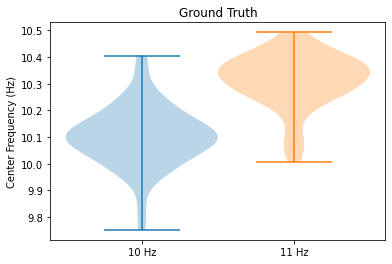

In [5]:
# Plot true classes
plt.violinplot(wf.y_array[::2, 0].astype(float))
plt.violinplot(wf.y_array[1::2, 0], positions=[1.5])

plt.title('Ground Truth')
plt.xticks([1, 1.5], labels=['10 Hz', '11 Hz'])
plt.ylabel('Center Frequency (Hz)')
plt.show()

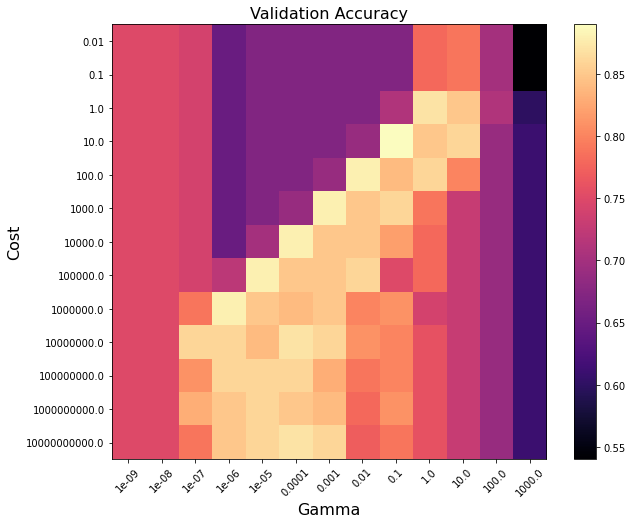

In [6]:
# Extract balanced accuracy metric from each fold in the CV
scores = wf.results.cv_results_['mean_test_score'].reshape(13, 13)

# Plot the grid search results
plt.figure(figsize=(10, 8))

plt.imshow(scores, interpolation="nearest", cmap=plt.cm.magma)
plt.xlabel("Gamma", size=16)
plt.ylabel("Cost", size=16)
plt.colorbar()

plt.xticks(np.arange(13), param_grid['gamma'], rotation=45)
plt.yticks(np.arange(13), param_grid['C'])

plt.title("Validation Accuracy", size=16)
plt.show()